# Fibonacci Swing - Human Nature

Let's let's let's have have have fun fun! Let's let's let's let's let's have have have have have fun fun fun!

In [1]:
# TODO: Show results of before and after here (audio files)

In [2]:
# Import libraries
%matplotlib inline

import os

import IPython.display as ipd
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

import bjorklund

## Feature extraction: detecting onsets and tempo

In [3]:
# Set parameters

# Load input audio file
# filename = "data/Michael Jackson - Human Nature.mp3"
filename = "data/humannature_30s.mp3"
# filename = "data/humannature_60s.mp3"
y, sr = librosa.load(filename)
ipd.Audio(y, rate=sr)

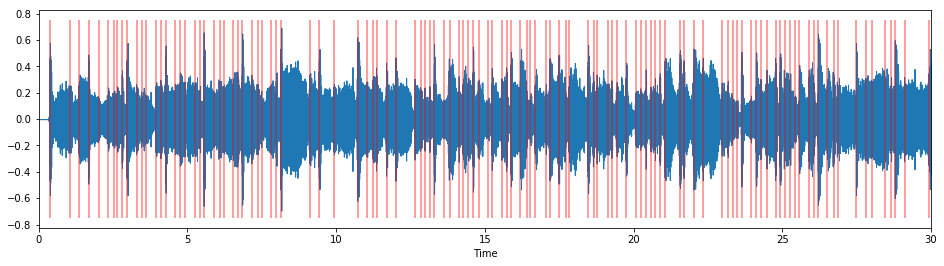

In [4]:
# Detect onsets
onset_frames = librosa.onset.onset_detect(y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames)
# print(onset_times)

# Plot onset times with original waveform
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sr)
plt.vlines(onset_times, -0.75, 0.75, color="r", alpha=0.5)

In [5]:
# Listen to onsets
onset_clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(y))
ipd.Audio(y + onset_clicks, rate=sr)

In [6]:
# Estimate tempo
onset_env = librosa.onset.onset_strength(y, sr=sr) # TODO: Compare this with librosa.beat.beat_track
onset_env
tempo = librosa.beat.tempo(y, sr=sr, onset_envelope=onset_env)
print("Tempo (calculated): {}".format(tempo))
tempo = np.array([93.0]) # Hard-coded to test
print("Tempo (hard-coded): {}".format(tempo))

Tempo (calculated): [ 92.28515625]
Tempo (hard-coded): [ 93.]


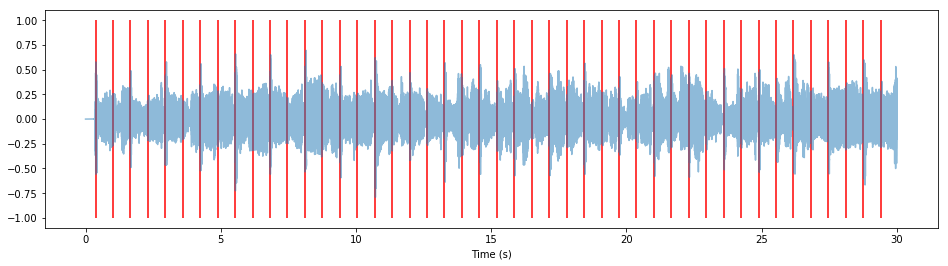

In [7]:
# Plot original waveform (essentially doing what librosa.display.waveplot does)
t = np.arange(0, len(y))/float(sr) # Ticks along x-axis; time in seconds
plt.figure(figsize=(16, 4))
plt.plot(t, y, alpha=0.5)
plt.xlabel("Time (s)")

# Calculate and plot beat times
T = len(y)/float(sr) # Total audio length in seconds
seconds_per_beat = 60.0/tempo
beat_times = np.arange(onset_times[0], T, seconds_per_beat) # Use onset_times[0] to start beat at first onset rather than time 0
plt.vlines(beat_times, -1, 1, color="r")

In [8]:
# Listen to beat clicks (i.e. a metronome)
beat_frames = librosa.time_to_frames(beat_times)
beat_clicks = librosa.clicks(frames=beat_frames, sr=sr, length=len(y))
ipd.Audio(y + beat_clicks, rate=sr)

In [9]:
beat_times

array([  0.37151927,   1.01668056,   1.66184186,   2.30700315,
         2.95216444,   3.59732573,   4.24248702,   4.88764831,
         5.5328096 ,   6.17797089,   6.82313218,   7.46829347,
         8.11345476,   8.75861605,   9.40377734,  10.04893863,
        10.69409992,  11.33926121,  11.9844225 ,  12.62958379,
        13.27474508,  13.91990637,  14.56506766,  15.21022895,
        15.85539024,  16.50055153,  17.14571282,  17.79087411,
        18.4360354 ,  19.08119669,  19.72635798,  20.37151927,
        21.01668056,  21.66184186,  22.30700315,  22.95216444,
        23.59732573,  24.24248702,  24.88764831,  25.5328096 ,
        26.17797089,  26.82313218,  27.46829347,  28.11345476,
        28.75861605,  29.40377734])

## Rhythmic manipulation by way of Fibonacci, Euclid, and Bjorklund

In [10]:
# Define rhythm parameters
original_subdivisions_per_beat = 2
original_beats_per_measure = 4
original_subdivisions_per_measure = original_subdivisions_per_beat * original_beats_per_measure
original_pulses_per_measure = 3
print("Original subdivisions per measure: {}".format(original_subdivisions_per_measure))

# Set target rhythm parameters
# TODO: Make this more extensible, esp with regards to the Fibonacci sequence
target_subdivisions_per_measure = 11
print("Target subdivisions per measure: {}".format(target_subdivisions_per_measure))

Original subdivisions per measure: 8
Target subdivisions per measure: 11


Let's take a quick detour into Euclid land

In [11]:
# Generate Euclidean rhythms via Bjorklund's algorithm
original_rhythm = bjorklund.bjorklund(original_subdivisions_per_measure, original_pulses_per_measure)
target_rhythm = bjorklund.bjorklund(target_subdivisions_per_measure, original_pulses_per_measure)
print("Original rhythm ({} pulses, {} subdivisions): {}\n"
      "Target rhythm ({} pulses, {} subdivisions):  {}".format(original_pulses_per_measure, original_subdivisions_per_measure, original_rhythm,
                                                                original_pulses_per_measure, target_subdivisions_per_measure, target_rhythm))

Original rhythm (3 pulses, 8 subdivisions): [1, 0, 0, 1, 0, 0, 1, 0]
Target rhythm (3 pulses, 11 subdivisions):  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


In [12]:
beat_samples = librosa.time_to_samples(beat_times)
beat_samples
# [y[s] for s in beat_samples]

array([  8192,  22417,  36643,  50869,  65095,  79321,  93546, 107772,
       121998, 136224, 150450, 164675, 178901, 193127, 207353, 221579,
       235804, 250030, 264256, 278482, 292708, 306933, 321159, 335385,
       349611, 363837, 378062, 392288, 406514, 420740, 434966, 449191,
       463417, 477643, 491869, 506095, 520321, 534546, 548772, 562998,
       577224, 591450, 605675, 619901, 634127, 648353])

In [46]:
# Calculate measure indices in samples
def calculate_measure_samples(y, beat_samples, beats_per_measure):
    max_samples = len(y)
    start_sample = beat_samples[0]
    beat_interval = beat_samples[1] - beat_samples[0]
    measure_interval = beat_interval * beats_per_measure
    if measure_interval >= beat_interval:
        return beat_samples[::beats_per_measure]
    else:
        # return np.arange(start_sample, max_samples, measure_interval)
        beat_indices = np.indices([len(beat_samples)])[0]
        measure_indices = np.indices([len(beat_samples)/beats_per_measure])[0]
        # print("Beat indices: {}, measure indices: {}".format(beat_indices, measure_indices))
        return np.interp(measure_indices, beat_indices/beats_per_measure, beat_samples)

measure_samples = calculate_measure_samples(y, beat_samples, original_beats_per_measure)
# measure_samples = calculate_measure_samples(y, beat_samples, 0.5) # Testing when measure_interval < beat_interval
measure_samples

array([  8192,  65095, 121998, 178901, 235804, 292708, 349611, 406514,
       463417, 520321, 577224, 634127])

In [ ]:
# def modify_track(y, sr=44100, measure_samples):

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]])